# README
This is our code. In the report we talk about slice 4 & 11 from dataset 7. These masks are also shown in the output along with the F1 score at the bottom. The output of the CNN approach is the second cell under the "Deep Learning Approach" header.  

The submission also contains notebook files with the cleaned up code for submission.

Predicted Mask (slice 4)


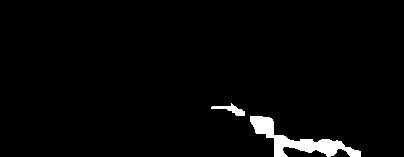

Actual Mask (slice 4)


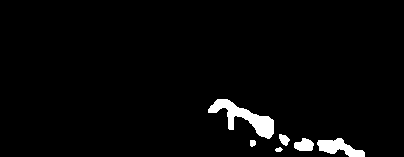

Predicted Mask (slice 11)


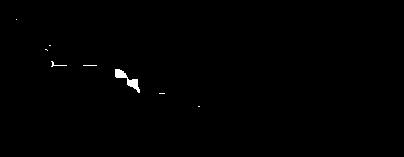

Actual Mask (slice 11)


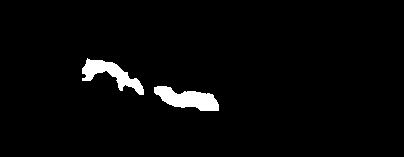

Final F1 Score: 0.4507895209043603


In [ ]:
path = '/content/7_image_and_mask.tiff'

# 4 is the index of the image that works well
# 11 bad

# 1 no mask but our model still makes a mask
# 20 no mask but our model slightly worked
predMasks, trueMasks = CIPT(path, 4, 11)

score = computeF1(predMasks, trueMasks)
print(f"Final F1 Score: {score}")


# Imports

In [ ]:
# Imports
import imageio
import statistics
from matplotlib import pyplot as plt # for displaying images
import cv2 #opencv for image processing
import imageio # another libaray for loading tiff images
import numpy as np # numpy import
from google.colab.patches import cv2_imshow
from sklearn.metrics import f1_score
import os


import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam

from albumentations import (
    Compose, Rotate, HorizontalFlip, VerticalFlip,
    RandomBrightnessContrast, Affine
)


import pywt

from PIL import ImageOps

from skimage import io, exposure

# Model
This is our model using classical image processing techniques (CIPT)

1. **CIPT()**

give a path to a .tiff file containing images and masks compute the predicted masks. Returns a stack of the predicted masks along with the true masks

In [ ]:
def CIPT(imagesPath, idxNum=None, idxNum2=None):
  """
  Perform our Classical Image Processing Technique (CIPT) model on a set of images.
  Requires the input file to be of the form "image_and_mask"

  Args:
    imagesPath (str): Path to input images and masks i.e "2_image_and_mask.tiff"
    idxNum (int): Index number to show predicted and true mask. Defaults to None

  Returns:
    predMasks (npArray): 3D array of all the predicted masks in order.
    trueMasks (npArray): 3D array of all the true masks in order.
  """

  # Parameters for morphological operations.
  kernelSize = (15,15)
  iterations = 2

  # Load images and split masks/images
  imgs = imageio.volread(imagesPath)
  images, trueMasks = splitImageAndMask(imgs)

  predMasks = []

  # Loop through all of the images do our model.
  for i in range(len(images)):

    filteredImage = homomorphic(images[i])

    # Segment out dendrite spin (white/black thresholding)
    threshImg = otsuMethod(filteredImage)

    # Find in focus area with sobel filter
    img = sobelFilter(filteredImage, threshold=150)

    # Close sobel filter result
    closedImg = performClosing(img, kernelSize=kernelSize, iterations=iterations)

    # Combine the spine mask with the closed sobel mask
    combinedMask = cv2.bitwise_and(closedImg, threshImg)
    if idxNum and i == idxNum:
      print("Predicted Mask (slice 4)")
      cv2_imshow(combinedMask)
      print("Actual Mask (slice 4)")
      cv2_imshow(trueMasks[i])

    if idxNum2 and i == idxNum2:
      print("Predicted Mask (slice 11)")
      cv2_imshow(combinedMask)
      print("Actual Mask (slice 11)")
      cv2_imshow(trueMasks[i])


    predMasks.append(combinedMask)

  return np.array(predMasks), np.array(trueMasks)

# Data Handling
These cells contain code just for handling the input data. **All of our project requires using the "image_and_mask" type files**

1. **splitImageAndMask()**
Splits an input image into the image and true mask.


















In [ ]:
def splitImageAndMask(images):
  """
  This function splits up the images and masks and returns two arrays, one for the images and one for the masks. For use with the "x_image_and_mask.tiff" files.

  Parameters:
    images (npArray): 3D np array containing all of the combined images and masks.

  Returns:
    imgs (list[npArray]): List containing just the input images.
    masks (list[npArray]): List containing just the true masks
  """
  num_images, height, width = images.shape
  # Create arrays to store the split images
  imgs = np.empty((num_images, height-1, width//2), dtype=images.dtype)
  masks = np.empty((num_images, height-1, width//2), dtype=images.dtype)

  # Loop through and split the images and masks
  for i in range(num_images):
    img = images[i]
    data = img[:(height-1),:(width//2)]
    mask = img[:(height-1), (width//2):]

    imgs[i] = data
    masks[i] = mask

  return imgs, masks


# Preprocessing
Cells here contain any preprocessing functions.

1. **homomorphic()**

Applies a homomorphic filter to an input image.

2. **otsuMethod()**

Applies thresholding using otsu's method to an image.

In [ ]:
#this function was generated with the help of chatgpt
#Prompt: write python code that does homomorphic filtering of a grayscale image
def homomorphic(image, cutoff_frequency=60, boost=1, gamma_low=0.5, gamma_high=1.5):
  """
  enhances mid to high frequencies while also preserving low frequencies

  parameters: image, cutoff frequency, boost, gamma_low, gamma_high
  returns: uint8 filtered image
  """

  image = np.float32(image)
  log_image = np.log1p(image)
  fft_image = np.fft.fft2(log_image)
  fft_shifted = np.fft.fftshift(fft_image)
  magnitude_spectrum = np.abs(fft_shifted)

  rows, cols = image.shape
  crow, ccol = rows // 2, cols // 2
  gaussian_filter = np.zeros((rows, cols), dtype=np.float32)
  for i in range(rows):
    for j in range(cols):
      gaussian_filter[i, j] = np.exp(-((i - crow) ** 2 + (j - ccol) ** 2) / (2 * cutoff_frequency ** 2))

  filtered_spectrum = fft_shifted * gaussian_filter
  filtered_spectrum_shifted = np.fft.ifftshift(filtered_spectrum)
  filtered_image = np.fft.ifft2(filtered_spectrum_shifted)
  filtered_image_magnitude = np.abs(filtered_image)
  filtered_image_magnitude = np.power(filtered_image_magnitude, boost)

  filtered_image_magnitude = (filtered_image_magnitude - np.min(filtered_image_magnitude)) / (
            np.max(filtered_image_magnitude) - np.min(filtered_image_magnitude))
  filtered_image_magnitude = filtered_image_magnitude * 255

  filtered_image_magnitude = np.power(filtered_image_magnitude, gamma_low)
  filtered_image_magnitude = np.power(filtered_image_magnitude, gamma_high)
  filtered_image_uint8 = np.uint8(filtered_image_magnitude)

  return filtered_image_uint8

In [ ]:
def otsuMethod(img):
  # Perform Otsu's method
  img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  # Invert it
  img = np.invert(img)
  return img

# In-Focus Detection
Methods to determine infocus areas of an image.

1. **sobelFilter()**

Applies a 3x3 sobel filter in the x and y direction. thresholds the result to get a mask of (hopefully) in focus areas of the image.

In [ ]:
def sobelFilter(image, threshold=100):
  """
  Given an image applies a sovel filter in the x and y directions using a 3x3 kernel.
  thresholds the result to get a binary mask.

  Args:
    image (npArray): Image for filter to be applied to.
    threshold (int): threshold value. Defaults to 100.

  Returns:
    focusedMask (npArray): Binary mask image after applying sobel filter.
  """

  gradx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
  grady = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

  gradMag = np.sqrt(gradx**2 + grady**2)
  gradMagNorm = cv2.normalize(gradMag, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
  focusedMask = cv2.threshold(gradMagNorm, threshold, 255, cv2.THRESH_BINARY)[1]

  return focusedMask

# Mask "Cleanup"
Once the in focus areas have been detected some small adjustments are made to "clean up" the final mask.

1. **performClosing()**

Does morphological closing on a binary image.

In [ ]:
def performClosing(img, kernelSize=(10,10), iterations=2):
  """
  Performs morphological closing of a given image

  Parameters:
    img (npArray): Input image to be closed.
    kernelSize ((int,int)): Kernel size for closing operation. Larger kernel = more aggressive closing.
    iterations (int): Number of iterations for closing. More iterations = more aggressive closing.

  Returns:
    closedImg (npArray): Final image that has been closed.
  """
  # Covert image to binary based off thresholding
  binImg = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
  # Make kernel
  kernel = np.ones(kernelSize, np.uint8)
  # Perform closing
  closedImg = cv2.morphologyEx(binImg, cv2.MORPH_CLOSE, kernel, iterations=iterations)
  return closedImg

# Evaluation
This section contains functions for our evaluation metrics.
Currently only have F1 score. Need to also get the accuracy.

In [ ]:
def computeF1(true_mask, pred_mask):
  """
  Computes the F1 score given two masks. Ranges between 0-1 with 0 sucking and 1 being perfect.

  Parameters:
    true_mask (npArray): True/actual mask that was given to us.
    pred_mask (npArray): Predicted mask.

  Returns:
    f1Score (float): F1 score between  the true and predicted masks.
  """
  if true_mask.shape != pred_mask.shape:
    raise ValueError("Error computing F1Score: true and predicted masks are different shapes.")


  # convert both masks into binary
  true_mask = np.where(true_mask == 255, 1, 0).flatten()
  pred_mask = np.where(pred_mask == 255, 1, 0).flatten()
  # Compute f1 score
  f1Score = f1_score(true_mask, pred_mask)

  return f1Score

# Deep Learning Approach
This was a quick experiment. Most of the code is AI generated with some tweaks; as a result we dont really understand it well but a lot of work can be done here:

1. Use U-Net Architecture as its really good for limited data sets in medical image processing
2. Do some data augmentation to artificially increase the dataset. (zooms, rotations. contrast adjustment ect.)

In [ ]:
def splitAndFlip(path='/content/7_image_and_mask.tiff'):

  imgs = imageio.volread(path)
  idx, height, width = imgs.shape[0], imgs.shape[1], imgs.shape[2]

  images, masks = [], []
  for i in range(idx):
    data = imgs[i, :(height-1), :(width//2)]
    mask = imgs[i, :(height-1), (width//2):]

    data = cv2.rotate(data, cv2.ROTATE_90_CLOCKWISE)
    mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
    # Pad Images so it can be fed into model
    data = padImages(data, 'image')
    # mask = padImages(mask, 'mask')
    # data = cv2.resize(data, (256, 512))
    # mask = cv2.resize(mask, (256, 512))
    # normalize resized image
    data = data / 255.0
    # Expand dimensions to fit CNN
    data = np.expand_dims(data, axis=[0,-1])



    images.append(data)
    masks.append(mask)

  return images, masks


1/1 [==============================] - 0s 340ms/step


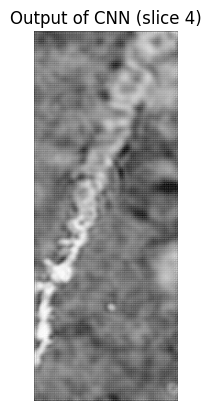

Predicted Mask CNN (slice 4)


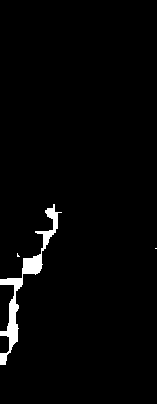

True Mask CNN (slice 4)


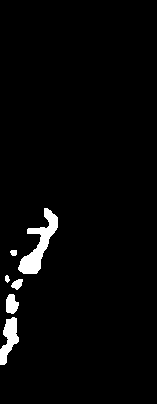

1/1 [==============================] - 0s 226ms/step


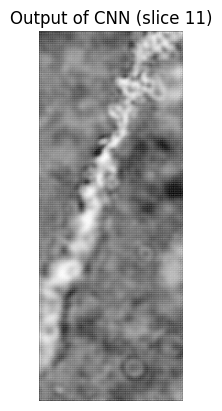

Predicted Mask CNN (slice 11)


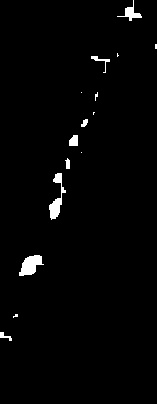

True Mask CNN (slice 11)


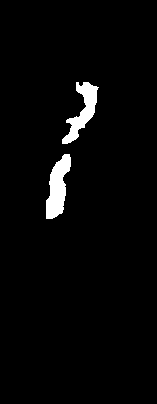

1/1 [==============================] - 0s 174ms/step
(25, 404, 157)
(25, 404, 157)
Final F1 Score: 0.39591413910236334


In [ ]:

# Load the image

testImages, testMasks = splitAndFlip()


# print(testImages[0].shape)

# height, width = testImages[0].shape[1], testImages[0].shape[2]

# print(testMasks[0].shape)

# cv2_imshow(testMasks[9])


threshold = 0.468
predMasks = []

for i in range(len(testImages)):
  predMask = model.predict(testImages[i])
  predMask = np.squeeze(predMask, axis=(0,-1))
  pred_Mask = unPad(predMask)
  predMask = (pred_Mask > threshold).astype(np.uint8)

  predicted_mask_binary = performClosing(predMask, kernelSize = (6,6))
  # What the F1 score method requires
  # predicted_mask_binary *= 255
  if i == 4:
    plt.imshow(pred_Mask, cmap='gray')
    plt.axis('off')
    plt.title("Output of CNN (slice 4)")
    plt.show()
    print('Predicted Mask CNN (slice 4)')
    cv2_imshow(predicted_mask_binary)
    print('True Mask CNN (slice 4)')
    cv2_imshow(testMasks[i])
  if i == 11:
    plt.imshow(pred_Mask, cmap='gray')
    plt.axis('off')
    plt.title("Output of CNN (slice 11)")
    plt.show()
    print('Predicted Mask CNN (slice 11)')
    cv2_imshow(predicted_mask_binary)
    print('True Mask CNN (slice 11)')
    cv2_imshow(testMasks[i])
  predMasks.append(predicted_mask_binary)

print(np.array(predMasks).shape)
print(np.array(testMasks).shape)

f1score = computeF1(np.array(predMasks), np.array(testMasks))
print(f"Final F1 Score: {f1score}")


# Model Training

In [ ]:
#

augmentation = Compose([
        Rotate(limit=40, p=0.5),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        Affine(scale={'x': (0.9, 1.1), 'y': (0.9, 1.1)}, translate_percent=None, rotate=0, shear=10, p=0.3)
    ])

model = unet()

train_gen = DataGenerator('/content/images', '/content/masks', batch_size=39, augmentations=augmentation)


history = model.fit(
    train_gen,
    epochs=12,
    steps_per_epoch=len(train_gen),
)


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history.get('val_accuracy', []))  # Only plot if validation accuracy exists
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history.get('val_loss', []))  # Only plot if validation loss exists
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')



Epoch 1/12


In [ ]:
# Save a good model!
model_name = ''
model.save(f'/content/{model_name}')

NameError: name 'model' is not defined

In [ ]:
def loadFiles(filePaths):
  """
  Load and format training images for model.
  """
  if not os.path.exists('/content/images'):
    os.makedirs('/content/images')

  if not os.path.exists('/content/masks'):
    os.makedirs('/content/masks')

  fileNum = 1


  for path in filePaths:
    imgs = imageio.volread(path)
    idx, height, width = imgs.shape[0], imgs.shape[1], imgs.shape[2]
    imageNum = 0

    for i in range(idx):
      imageNum += 1
      # Split image and mask
      data = imgs[i, :(height-1), :(width//2)]
      mask = imgs[i, :(height-1), (width//2):]

      data = padImages(data, "image")
      mask = padImages(mask, 'mask')


      ### ADD STUFF HERE FOR HANDLING DIFFERENT IMAGE SHAPES ###

      imagePath = os.path.join('/content/images', f'image_{fileNum:01d}_{imageNum:02d}.png')
      maskPath = os.path.join('/content/masks', f'mask_{fileNum:01d}_{imageNum:02d}.png')
      # Save to specified directory
      cv2.imwrite(imagePath, data)
      cv2.imwrite(maskPath, mask)

    fileNum += 1



!rm -rf images/
!rm -rf masks/
filePaths = ['3_image_and_mask.tiff', '6_image_and_mask.tiff']
loadFiles(filePaths)

FileNotFoundError: No such file: '/content/3_image_and_mask.tiff'

In [ ]:
!unzip -o /content/7e_16bs.zip
model = tf.keras.models.load_model('content/7e_16bs')


Archive:  /content/7e_16bs.zip
   creating: content/7e_16bs/
  inflating: content/7e_16bs/saved_model.pb  
   creating: content/7e_16bs/variables/
  inflating: content/7e_16bs/variables/variables.index  
  inflating: content/7e_16bs/variables/variables.data-00000-of-00001  
 extracting: content/7e_16bs/fingerprint.pb  
  inflating: content/7e_16bs/keras_metadata.pb  
   creating: content/7e_16bs/assets/


In [ ]:
def unet(input_shape=(512, 256, 1)):
    inputs = Input(input_shape)

    # Downscaling path
    c1 = Conv2D(16, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottom of the U
    c3 = Conv2D(64, (3, 3), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)

    # Upscaling path
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(32, (3, 3), padding='same')(u1)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    u2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = concatenate([u2, c1], axis=3)
    c5 = Conv2D(16, (3, 3), padding='same')(u2)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size, augmentations=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
        self.batch_size = batch_size
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_img_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        imgs = np.zeros((self.batch_size, 512, 256, 1), dtype=np.uint8)
        masks = np.zeros((self.batch_size, 512, 256, 1), dtype=np.uint8)

        for i, (img_path, mask_path) in enumerate(zip(batch_img_paths, batch_mask_paths)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # img = padImages(image)
            # mask = padImages(mask)

            if self.augmentations:
                augmented = self.augmentations(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

            imgs[i] = np.expand_dims(img, axis=-1) / 255.0
            masks[i] = np.expand_dims(mask, axis=-1) / 255.0

        return imgs, masks

In [ ]:
def padImages(image, imgType, outputHeight=512, outputWidth=256):
    height, width = image.shape[:2]

    padHeight = (outputHeight - height) // 2
    padWidth = (outputWidth - width) // 2

    botPad = outputHeight - height - padHeight
    rightPad = outputWidth - width - padWidth

    if padHeight < 0 or padWidth < 0 or botPad < 0 or rightPad < 0:
        raise ValueError("IMAGE IS TOO BIG PADDING IS NEGATIVE STOPPPPPPP")

    # Need to pad images with the correct background color
    # i.e white for input images and black for masks
    if imgType == 'image':
      padValue = 255
    elif imgType == 'mask':
      padValue = 0

    paddedImage = np.pad(image, ((padHeight, botPad), (padWidth, rightPad)), mode='constant', constant_values=padValue)

    return paddedImage

In [ ]:
def unPad(image, ogHeight = 404, ogWidth=157):
  # shape of image will always be this after unet
  height, width = 512, 256
  padHeight = height - ogHeight
  padWidth = width - ogWidth

  startHeight = padHeight // 2
  startWidth = padWidth // 2

  endHeight = startHeight + ogHeight
  endWidth = startWidth + ogWidth

  unPadImage = image[startHeight:endHeight, startWidth:endWidth]

  return unPadImage
